In [98]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import h5py

import torch

In [141]:
# Load data

n = 10
with h5py.File('/Volumes/ES-HDD-Documents/Documents/CFHT_galaxies_with_streams/train_data.h5', 'r') as f:
    images = f['images'][:n] # (N, 1, H, W)
    masks  = f['masks'][:n]  # (N, 1, H, W)
images = np.transpose((images*255).astype(np.uint8), (0, 2, 3, 1)) # From NCHW to NHWC

images = images[:,:,:,0]
masks  = masks[:,0,:,:]

In [135]:
with h5py.File(f'{path_input}/train_data.h5', 'r') as f:
    valid_images = (f['images'][:n,0,:,:]*255).astype(np.uint8) # (N, H, W)
    valid_masks  = f['masks'][:n,0,:,:]  # (N, H, W)

In [142]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

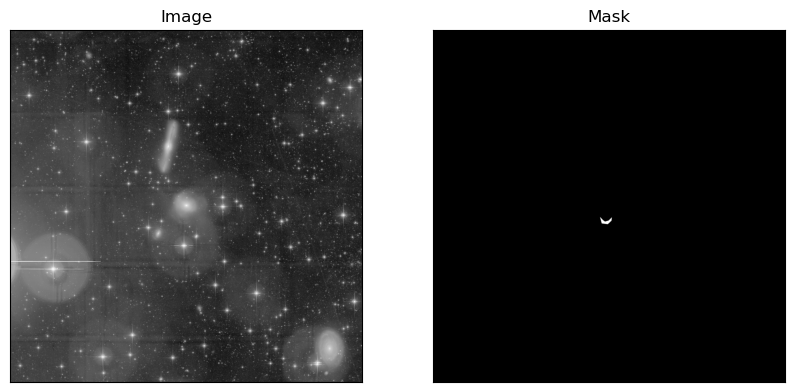

In [123]:
import random 

img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [148]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [149]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [150]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [151]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [152]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (3333, 3333)


In [153]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)

In [154]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 3333, 3333])


In [77]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [23]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

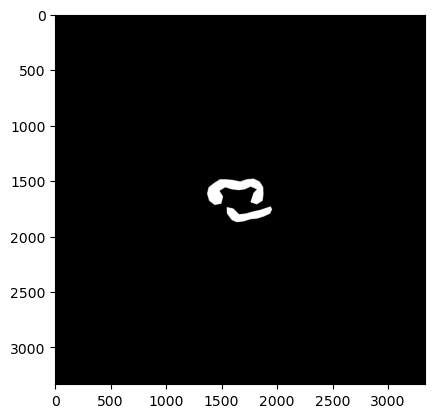

In [38]:
plt.imshow(ground_truth_masks[0].numpy(), cmap='gray')

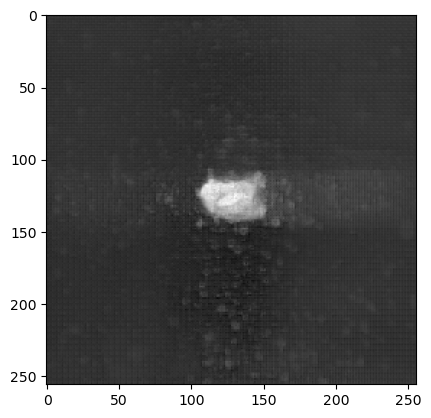

In [36]:
plt.imshow(outputs.pred_masks.squeeze(1)[0,0].detach().cpu().numpy(), cmap='gray')

In [68]:
a = outputs.pred_masks.squeeze(1)[0,0]

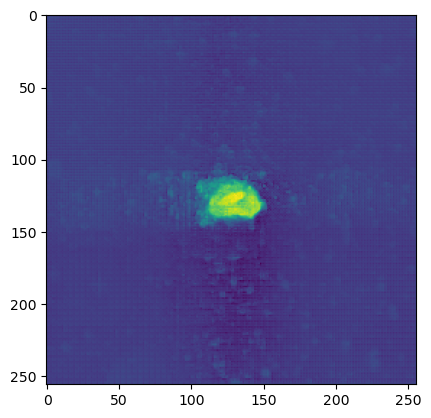

In [69]:
plt.imshow(a.detach().numpy())

In [54]:
a

tensor([[ -9.5153,  -9.8559,  -9.3841,  ...,  -9.4097,  -9.1728,  -9.1844],
        [ -9.8188, -10.2220,  -9.7693,  ...,  -9.6039,  -9.8052,  -9.5963],
        [ -9.3583,  -9.6119,  -9.6914,  ...,  -9.0445,  -9.4999,  -9.2494],
        ...,
        [ -9.7937, -10.3861,  -9.5845,  ...,  -9.2483,  -9.7919,  -9.2696],
        [ -9.3971,  -9.6279,  -9.2801,  ...,  -8.8996,  -9.6429,  -9.3118],
        [ -9.4838,  -9.8262,  -9.5520,  ...,  -8.9949,  -9.4051,  -9.3592]],
       grad_fn=<SelectBackward0>)

In [67]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      upscaled_predicted_masks = torch.nn.functional.interpolate(predicted_masks, size=(3333,3333))
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(upscaled_predicted_masks, ground_truth_masks.unsqueeze(1))
      

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

 40%|████      | 2/5 [01:03<01:34, 31.52s/it]


KeyboardInterrupt: 

In [155]:
import h5py
import monai
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import datasets

from transformers import SamProcessor
from transformers import SamModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE  = torch.float32

# Parameters
lr = 1e-5
wd = 0
num_epochs = 100
bs = 1

path_input  = '/Volumes/ES-HDD-Documents/Documents/CFHT_galaxies_with_streams'
path_output = '.'

# Load Train and Valid data
n = 5
with h5py.File(f'{path_input}/train_data.h5', 'r') as f:
    train_images = (f['images'][:n,0,:,:]*255).astype(np.uint8) # (N, H, W)
    train_masks  = f['masks'][:n,0,:,:]  # (N, H, W)

with h5py.File(f'{path_input}/val_data.h5', 'r') as f:
    valid_images = (f['images'][:n,0,:,:]*255).astype(np.uint8) # (N, H, W)
    valid_masks  = f['masks'][:n,0,:,:]  # (N, H, W)


# Convert the NumPy arrays to Pillow images and store them in a dictionary
train_dataset_dict = {
    "image": [Image.fromarray(img) for img in train_images],
    "label": [Image.fromarray(mask) for mask in train_masks],
}

valid_dataset_dict = {
    "image": [Image.fromarray(img) for img in valid_images],
    "label": [Image.fromarray(mask) for mask in valid_masks],
}

# Create the dataset using the datasets.Dataset class
t_dataset = datasets.Dataset.from_dict(train_dataset_dict)
v_dataset = datasets.Dataset.from_dict(valid_dataset_dict)

#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs
  
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=t_dataset, processor=processor)
valid_dataset = SAMDataset(dataset=v_dataset, processor=processor)

# Create a DataLoader instance for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, drop_last=False)

# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [156]:
#Training and Validation loop
model.to(DEVICE)

loss_train_epoch = []
loss_valid_epoch = []
for epoch in tqdm(range(num_epochs), leave=True):

    loss_train_batch = []
    loss_valid_batch = []   

    # Training 
    model.train()
    for batch in tqdm(train_dataloader):
      
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(DEVICE),
                      input_boxes=batch["input_boxes"].to(DEVICE),
                      multimask_output=False)

      # compute loss
      ground_truth_masks = batch["ground_truth_mask"].float().to(DEVICE)
      predicted_masks = outputs.pred_masks.squeeze(1)
      upscaled_predicted_masks = torch.nn.functional.interpolate(predicted_masks, size=(ground_truth_masks.shape[-2],ground_truth_masks.shape[-1]))
      loss = seg_loss(upscaled_predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      loss_train_batch.append(loss.item())

    # Validation
    model.eval()
    for batch in tqdm(valid_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(DEVICE),
                      input_boxes=batch["input_boxes"].to(DEVICE),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      upscaled_predicted_masks = torch.nn.functional.interpolate(predicted_masks, size=(H,W))
      ground_truth_masks = batch["ground_truth_mask"].float().to(DEVICE)
      loss = seg_loss(upscaled_predicted_masks, ground_truth_masks.unsqueeze(1))
      
      loss_valid_batch.append(loss.item())

    loss_train_epoch.append(np.mean(loss_train_batch))
    loss_valid_epoch.append(np.mean(loss_valid_batch))

    print(f'EPOCH: {epoch}')
    print(f'Train loss: {loss_train_epoch[epoch]}, Valid loss: {loss_valid_epoch[epoch]}')

    # Save and Plot loss
    np.savetxt(f'{path_output}/train_losses.txt', loss_train_epoch)
    np.savetxt(f'{path_output}/valid_losses.txt', loss_valid_epoch)
    plt.plot(loss_train_epoch, color='blue', label='train')
    plt.plot(loss_valid_epoch, color='orange', label='valid')
    plt.semilogy()
    plt.legend(loc='upper right')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'{path_output}/loss.png')
    plt.close()

    # Save model
    torch.save(model.state_dict(), f'{path_output}/finetuned_SAM.pth')

  0%|          | 0/100 [01:24<?, ?it/s]


KeyboardInterrupt: 